<a href="https://colab.research.google.com/github/jhwnoh/UST-GenerativeModels/blob/master/RE_P2_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

Define functions used for model construction

In [2]:
import rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import MolFromSmiles,MolToSmiles
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

def LinearAnnealing(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

class MolData(Dataset):
    def __init__(self,smis,toks):
        self.smis = smis
        self.toks = toks + ['<','>'] #'<'; start of sequence, '>'; end of sequence
        self.Ntok = len(toks)
        self.Nmax = 120

    def __len__(self):
        return len(self.smis)

    def __getitem__(self,idx):
        smi = '<'+self.smis[idx]+'>'
        smi += '>'*(self.Nmax-len(smi))

        x_all = np.array([self.toks.index(s) for s in smi]).flatten()

        y = x_all[1:] #output

        x = torch.LongTensor(x_all)
        y = torch.LongTensor(y)
        return x,y

class MolVAE(nn.Module):
    def __init__(self,dim_x0,dim_x1,dim_h,n_layer,d_ratio,dim_z):
        super(MolVAE,self).__init__()
        self.n_layer = n_layer
        self.emb_layer = nn.Embedding(dim_x0,dim_x1)

        self.enc = nn.GRU(dim_x1,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.fc_z1 = nn.Sequential(
                        nn.Linear(dim_h,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,2*dim_z))

        self.fc_z2 = nn.Linear(dim_z,dim_h)

        self.dec = nn.GRU(dim_x1+dim_z,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.out = nn.Sequential(
                        nn.Linear(dim_h,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,dim_x0))

    def forward(self,x):
        x_emb = self.emb_layer(x)

        mu,log_var = self.encoder(x_emb)
        eps = torch.randn_like(mu)
        z = mu + eps*torch.exp(log_var/2)

        out = self.decoder(x_emb[:,:-1],z)
        return out,mu,log_var

    def encoder(self,x):
        _,h1 = self.enc(x,None)
        h2 = self.fc_z1(h1[-1])
        mu,log_var = torch.chunk(h2,2,dim=-1)
        return mu,log_var

    def decoder(self,x,z):
        N,L,F = x.shape
        h0_z = z.unsqueeze(1).repeat(1,L,1)

        x_in = torch.cat([x,h0_z],dim=-1)

        h0_rnn = self.fc_z2(z).unsqueeze(0).repeat(self.n_layer,1,1)
        out,h_d = self.dec(x_in,h0_rnn)
        out = self.out(out)
        return out

    def sampling(self,x0,z,h0=None,is_first=True):
        x = self.emb_layer(x0)

        N,L,F = x.shape
        h0_z = z.unsqueeze(1).repeat(1,L,1)
        x_in = torch.cat([x,h0_z],dim=-1)

        if is_first:
            h0 = self.fc_z2(z).unsqueeze(0).repeat(self.n_layer,1,1)

        out,h1 = self.dec(x_in,h0)
        out = self.out(out)
        return out,h1


Generating molecules from latent space

In [3]:
def Sampling(sampler,dim_z,n_sample,max_len,tok_lib):
    sampler.eval()
    with torch.no_grad():
        inits = torch.LongTensor([34]*n_sample)
        loader = DataLoader(inits,batch_size=100)

        Sampled = []
        Zs = []
        for inp in tqdm(loader):
            x_in = inp.reshape(-1,1)

            x_hat = []
            z = torch.randn(len(x_in),dim_z)
            h = None
            is_first = True
            for seq_iter in range(max_len):

                if seq_iter > 0:
                    is_first = False

                out,h = sampler.sampling(x_in,z,h,is_first)
                prob = F.softmax(out,dim=-1).squeeze(1)
                x_in = torch.multinomial(prob,1)
                #x_in = torch.argmax(prob,1).view(-1,1)

                x_hat.append(x_in.cpu().detach().numpy())

            x_hat = np.hstack(x_hat)
            Sampled.append(x_hat)
            Zs.append(z.cpu().detach().numpy())

    Sampled = np.vstack(Sampled)
    Zs = np.vstack(Zs)

    Mols = []
    Lat1 = []
    for s,z in zip(Sampled,Zs):
        n_end = np.sum(s==35)

        if n_end == 0:
            continue

        n = np.min(np.where(s==35)[0])
        m = ''.join(tok_lib[s[:n]].tolist())
        Mols.append(m)
        Lat1.append(z)

    Vals = []
    Lat2 = []
    for smi,z in zip(Mols,Lat1):
        mol = MolFromSmiles(smi)
        if not mol is None:
            Vals.append(MolToSmiles(mol))
            Lat2.append(z.reshape(1,-1))

    Uni = list(set(Vals))
    Lat2 = np.vstack(Lat2)
    return Vals,Lat2,len(Vals),len(Uni)

Training and validation check

In [6]:
import numpy as np
import pandas as pd
import os

import pickle

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

df = pd.read_csv('https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/main/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv')
smi_ = [ss.split()[0] for ss in df['smiles']]

toks = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/UST_GM_week13/UST-VAE/ZINC_Tokens.pkl','rb')) #본인이 가진 파일 경로로 수정

np.random.seed(1)
np.random.shuffle(smi_)

n_train = 200000
n_val = 25000
n_t = 25000

smi_train = smi_[:n_train][:1000]
smi_val = smi_[n_train:n_train+n_val][:1000]

batch_size = 64

train_data = MolData(smi_train,toks)
tok_lib = np.array(train_data.toks) # For sampling
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

test_data = MolData(smi_val,toks)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

DimZ = 128
model = MolVAE(36,64,256,2,0.2,DimZ)

lr = 1e-4
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

num_epoch = 200
max_norm = 5

LOGs = []
Betas = LinearAnnealing(n_iter=num_epoch,start=0.0,stop=0.2).tolist()

for ep in range(num_epoch):
    model.train()
    for inp in tqdm(train_loader):
        x_in = inp[0]
        tgt = inp[1].view(-1)

        x_out,mu,log_var = model(x_in)

        rec = ce_loss(x_out.reshape(-1,36),tgt)
        kld = torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1))

        loss = rec + Betas[ep]*kld

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        Sim = []
        Mus = []
        Stds = []
        KLDs = 0
        Ns = 0
        for inp in tqdm(test_loader):
            x_in = inp[0]
            tgt = inp[1].view(-1)

            x_out,mu,log_var = model(x_in)

            kld = torch.sum(torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1),-1))

            KLDs += kld.cpu().detach().numpy().flatten()[0]
            Ns += len(x_in)

            id_out = np.argmax(x_out.cpu().detach().numpy(),-1)
            id_in = x_in[:,1:].cpu().detach().numpy()
            acc = np.mean(id_out==id_in,1).reshape(-1,1)

            Sim.append(acc)
            Mus.append(mu.cpu().detach().numpy())
            Stds.append(torch.exp(log_var/2).cpu().detach().numpy())

        Sim = np.vstack(Sim)
        Mus = np.vstack(Mus)
        Stds = np.vstack(Stds)
        mols,Zs,val,uniq = Sampling(model,DimZ,100,120,tok_lib)

        print(ep,Betas[ep],np.mean(Sim),KLDs/Ns,mols[0],val,uniq)

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


0 0.0 0.6351680672268907 0.01767553889751434  2 1


 12%|█▎        | 2/16 [00:04<00:33,  2.42s/it]


KeyboardInterrupt: ignored

미리 학습된 모델 불러와서 샘플링 해보기

In [7]:
DimZ = 156
model = MolVAE(36,128,480,3,0.2,DimZ)

chkpt = torch.load('/content/drive/MyDrive/Colab Notebooks/UST_GM_week13/UST-VAE/Model_VAE.pth.tar',map_location='cpu') #본인이 가진 파일 경로로 수정
model.load_state_dict(chkpt['state_dict'])

mols,Zs,val,uniq = Sampling(model,DimZ,5000,120,tok_lib) #5000개 분자 샘플링

100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


(array([1.000e+00, 1.300e+01, 1.700e+02, 7.780e+02, 1.379e+03, 1.293e+03,
        5.470e+02, 1.870e+02, 5.400e+01, 1.600e+01]),
 array([ 8. , 15.2, 22.4, 29.6, 36.8, 44. , 51.2, 58.4, 65.6, 72.8, 80. ]),
 <BarContainer object of 10 artists>)

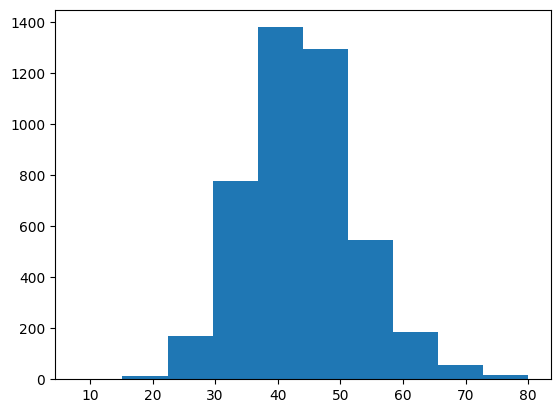

In [8]:
mol_size = [len(smi) for smi in mols]

import matplotlib.pyplot as plt
plt.hist(mol_size)

Validation set에 대해서 latent vector 샘플링 후 분석

In [14]:
smi_val = smi_[n_train:n_train+n_val][:2000]

test_data = MolData(smi_val,toks)
test_loader = DataLoader(test_data,batch_size=100,shuffle=False)

model.eval()
with torch.no_grad():
        Sim = []
        Mus = []
        Stds = []
        KLDs = 0
        Ns = 0
        for inp in tqdm(test_loader):
            x_in = inp[0]
            tgt = inp[1].view(-1)

            x_out,mu,log_var = model(x_in)

            kld = torch.sum(torch.mean(0.5*(mu**2+torch.exp(log_var)-log_var-1),-1))

            KLDs += kld.cpu().detach().numpy().flatten()[0]
            Ns += len(x_in)

            id_out = np.argmax(x_out.cpu().detach().numpy(),-1)
            id_in = x_in[:,1:].cpu().detach().numpy()
            acc = np.mean(id_out==id_in,1).reshape(-1,1)

            Sim.append(acc)
            Mus.append(mu.cpu().detach().numpy())
            Stds.append(torch.exp(log_var/2).cpu().detach().numpy())

        Sim = np.vstack(Sim)
        Mus = np.vstack(Mus)
        Stds = np.vstack(Stds)

100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


100%|██████████| 156/156 [00:06<00:00, 22.63it/s]


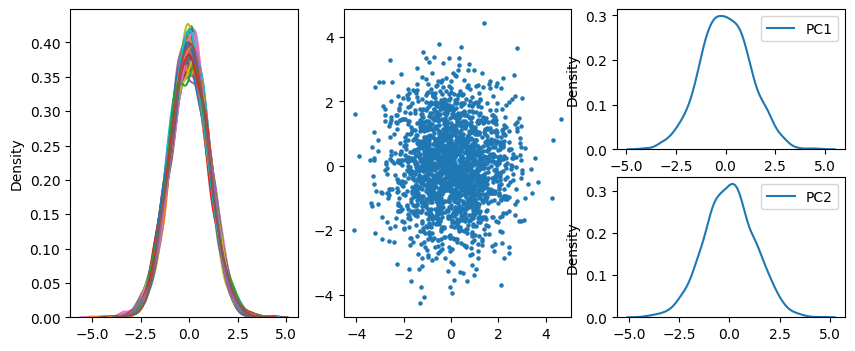

In [18]:
z_val = Mus + np.random.randn(Mus.shape[0],Mus.shape[1])*Stds

from sklearn.decomposition import PCA

pca = PCA(2).fit(z_val)
pc_val = pca.transform(z_val)

import seaborn as sns
from tqdm import tqdm

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
for i in tqdm(range(z_val.shape[1])):
    sns.kdeplot(z_val[:,i])

plt.subplot(1,3,2)
plt.scatter(pc_val[:,0],pc_val[:,1],marker='o',s=5)

plt.subplot(2,3,3)
sns.kdeplot(pc_val[:,0],label='PC1')
plt.legend(loc='best')

plt.subplot(2,3,6)
sns.kdeplot(pc_val[:,1],label='PC2')
plt.legend(loc='best')

Randomly sampled data에 대해 latent space visualization

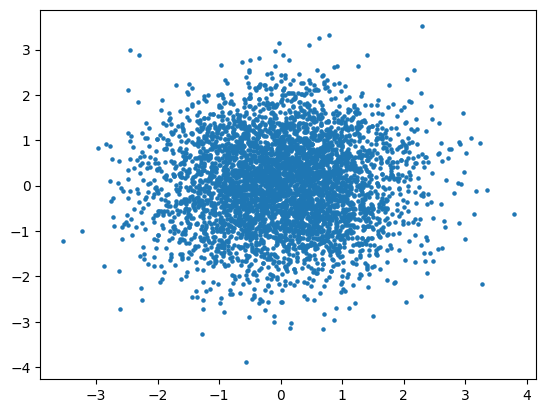

In [20]:
pc_sampled = pca.transform(Zs)
plt.scatter(pc_sampled[:,0],pc_sampled[:,1],marker='o',s=5)